## Rats

In [145]:
import numpy as np
import scipy.stats as stats

# Données de l'exemple
np.random.seed(42)
N = 30
T = 5
x_bar = 22
x = np.array([8, 15, 22, 29, 36])
y = np.array([
    [151, 199, 246, 283, 320],
    [145, 199, 249, 293, 354],
    [147, 214, 263, 297, 328],
    [155, 200, 237, 285, 323],
    [135, 188, 252, 275, 297],
    [159, 210, 230, 298, 331],
    [141, 189, 231, 280, 305],
    [159, 201, 248, 312, 338],
    [177, 236, 231, 289, 376],
    [134, 182, 252, 273, 314],
    [160, 208, 244, 289, 325],
    [143, 188, 242, 288, 358],
    [154, 200, 243, 280, 312],
    [171, 221, 248, 283, 316],
    [163, 207, 259, 295, 336],
    [160, 187, 243, 286, 321],
    [142, 203, 253, 298, 334],
    [156, 212, 246, 286, 302],
    [157, 203, 253, 298, 331],
    [152, 205, 248, 289, 345],
    [154, 190, 244, 286, 316],
    [139, 191, 250, 291, 333],
    [146, 211, 257, 297, 316],
    [157, 207, 257, 295, 291],
    [132, 185, 244, 289, 324],
    [160, 207, 261, 297, 324],
    [169, 216, 248, 289, 324],
    [157, 205, 253, 298, 324],
    [137, 180, 243, 286, 324],
    [153, 200, 244, 286, 324]
])

#Hyperparamètres 

hyper_prior = [0,0.000001,0.001,0.001]

# Initialisation des paramètres
init = [0, 0, 0.001, 0.001, 0.001]

# Nombre d'itérations
nchain = 10000

def rats(nchain, init, x, y, hyper_prior):

    mu_c = hyper_prior[0]
    tau_d = hyper_prior[1]
    alpha_tau = hyper_prior[2]
    beta_tau = hyper_prior[3]

    chain = np.zeros((nchain + 1, 5))
    latent_alpha = np.zeros((nchain + 1, N))
    latent_beta = np.zeros((nchain + 1, N))
    chain[0,:] = init #[beta_c, alpha_c, tau_alpha, tau_beta, tau_c]

    # MCMC Gibbs Sampling
    for t in range(nchain):

        beta_c, alpha_c, tau_alpha, tau_beta, tau_c = chain[t,:]
        latent_alpha_cur = latent_alpha[t,:]
        latent_beta_cur = latent_beta[t,:]
        
        for i in range(N):
            ## Update the latent variables (alpha_i et beta_i)

            ## Update alpha_i
            mu_alpha_i = (tau_alpha * alpha_c + tau_c * np.sum(y[i] - latent_beta_cur[i] * (x - x_bar))) / (T * tau_c + tau_alpha)
            sigma2_alpha_i = 1 / (T * tau_c + tau_alpha)
            latent_alpha_cur[i] = np.random.normal(loc=mu_alpha_i, scale=np.sqrt(sigma2_alpha_i))

            ## Update beta_i
            mu_beta_i = (tau_beta * beta_c + tau_c * np.sum((y[i] - latent_alpha_cur[i]) * (x - x_bar))) / (np.sum((x - x_bar)**2) * tau_c + tau_beta)
            sigma2_beta_i = 1 / (np.sum((x-x_bar)**2) * tau_c + tau_beta)
            latent_beta_cur[i] = np.random.normal(loc=mu_beta_i, scale=np.sqrt(sigma2_beta_i))

        # Update alpha_c
        mu_alpha_c = (tau_alpha * np.sum(latent_alpha_cur)) / (tau_d + N * tau_alpha)
        sigma2_alpha_c = 1 / (tau_d + N * tau_alpha)
        alpha_c = np.random.normal(loc=mu_alpha_c, scale=np.sqrt(sigma2_alpha_c))

        # Update beta_c
        mu_beta_c = (tau_beta * np.sum(latent_beta_cur)) / (N * tau_beta + tau_d)
        sigma2_beta_c = 1 / (N * tau_beta + tau_d)
        beta_c = np.random.normal(loc=mu_beta_c, scale=np.sqrt(sigma2_beta_c))

        # Update tau_alpha
        shape_fcond = N/2 + alpha_tau
        scale_fcond = beta_tau + 0.5 * np.sum((latent_alpha_cur - alpha_c)**2)
        tau_alpha =  np.random.gamma(shape=shape_fcond, scale=1/scale_fcond)

        # Update tau_beta
        shape_fcond = N/2 + alpha_tau
        scale_fcond = beta_tau + 0.5 * np.sum((latent_beta_cur - beta_c)**2)
        tau_beta =  np.random.gamma(shape=shape_fcond, scale=1/scale_fcond)

        # Update tau_c
        residuals = y - (latent_alpha_cur[:, np.newaxis] + latent_beta_cur[:, np.newaxis] * (x - x_bar))
        shape_fcond = N*T/2 + alpha_tau
        scale_fcond = beta_tau + 0.5 * np.sum(residuals**2)
        tau_c = np.random.gamma(shape=shape_fcond, scale=1/scale_fcond)

        # Update the chain
        chain[t + 1, :] = [beta_c, alpha_c, tau_alpha, tau_beta, tau_c]
        latent_alpha[t + 1, :] = latent_alpha_cur
        latent_beta[t + 1, :] = latent_beta_cur

    return chain, latent_alpha, latent_beta


In [149]:
chain, latent_alpha, latent_beta = rats(nchain, init, x, y, hyper_prior)

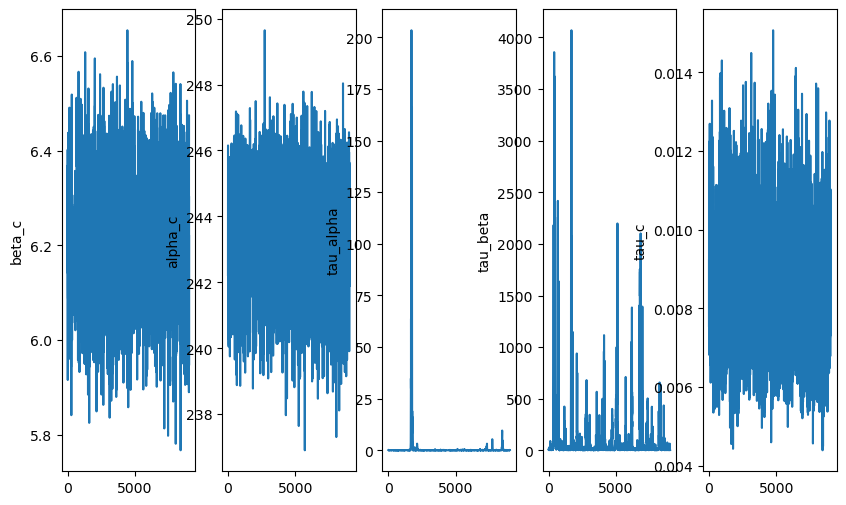

In [187]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
ylabs = ["beta_c", "alpha_c", "tau_alpha", "tau_beta", "tau_c"]
chain_burn = chain[1000:,:]
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.plot(chain_burn[:,i])
    plt.ylabel(ylabs[i])
plt.savefig("premier.png")

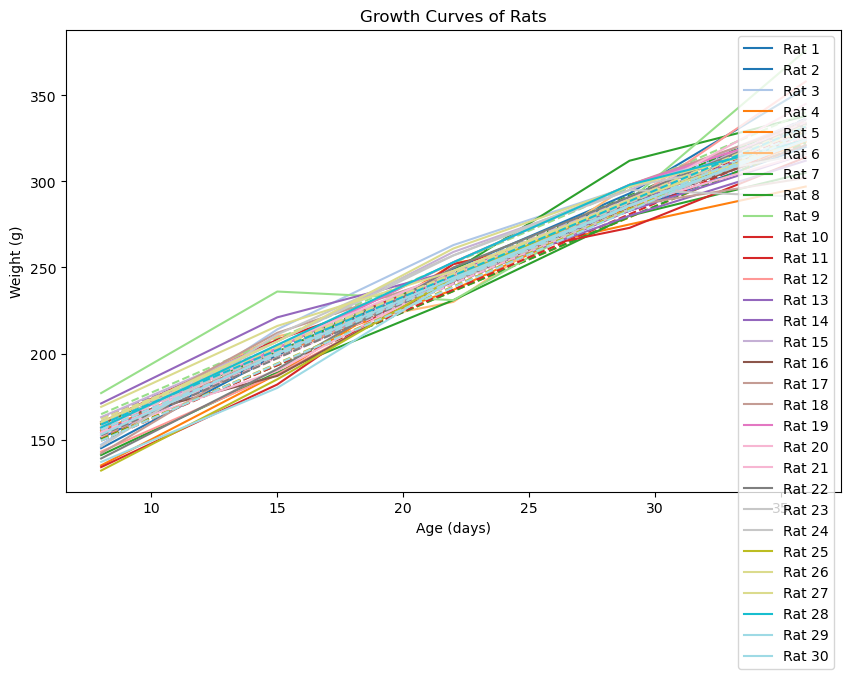

In [185]:
post_mean_latent_alpha = np.mean(latent_alpha, axis = 0)
post_mean_latent_beta = np.mean(latent_beta, axis = 0)

colors = plt.cm.tab20(np.linspace(0, 1, 30))
# Tracer les courbes de croissance
plt.figure(figsize=(10, 6))

for i in range(30):
    plt.plot(x, y[i], label=f'Rat {i+1}', color=colors[i])

    # Calculer l'intercept et la pente pour chaque rat
    intercept = post_mean_latent_alpha[i]
    slope = post_mean_latent_beta[i]

    # Tracer la ligne de régression
    plt.plot(x, intercept + slope * (x - x_bar), linestyle='--', color=colors[i])

plt.xlabel('Age (days)')
plt.ylabel('Weight (g)')
plt.title('Growth Curves of Rats')
plt.legend()
plt.savefig("allrat1.png")
plt.show()

In [179]:
import numpy as np

means = np.mean(chain_burn, axis=0)

variances = np.var(chain_burn, axis=0)

for i, param in enumerate(["beta_c", "alpha_c", "tau_alpha", "tau_beta", "tau_c"]):
    print(f"{param}: mean = {means[i]}, ecart type = {np.sqrt(variances[i])}")

sigma= 1/np.sqrt(chain_burn[4])
print(np.mean(sigma))
print(np.sqrt(np.var(sigma)))

beta_c: mean = 6.207464128248706, ecart type = 0.10749588576862497
alpha_c: mean = 243.2043369398858, ecart type = 1.3369855948169136
tau_alpha: mean = 0.6916563165956638, ecart type = 7.218738803400977
tau_beta: mean = 80.72296071660415, ecart type = 234.93878388111582
tau_c: mean = 0.008503616218912376, ecart type = 0.001378410702798107
3.5613266656492515
4.090555536284938


In [177]:
print(f"alpha0 : mean = {means[1] - x_bar*means[0]}")
print(f"alpha0 : ecart type = {np.sqrt(variances[1] + (x_bar**2)*variances[0])}")

-1079.3124825974962
alpha0 : mean = 106.64012611841426
alpha0 : ecart type = 2.7166757925861655


In [195]:
print(np.quantile(chain_burn[0], [0.025, 0.975]))
print(np.quantile(sigma, [0.025, 0.975]))

[1.63512742e-02 2.18836130e+02]
[0.09728125 9.52791956]


## Birats

In [60]:
import numpy as np
import scipy.stats as stats

# Données de l'exemple
np.random.seed(42)
N = 30
T = 5
omega = np.array([[0.005, 0], [0, 5]])

R = np.array([[200, 0], [0, 0.2]])
rho = 2 

#Hyperparamètres 
mean_prior = np.array([0,0])
prec_prior = np.diag([1e-6,1e-6])

hyper_prior = [mean_prior, prec_prior, rho, R, 0.001, 0.001]

# Initialisation des paramètres
init = {
    'mu_beta': np.array([0, 0]), 
    'tau_c': 0.01,                      
    'Omega': omega       
}


# Nombre d'itérations
nchain = 10000

def birats(nchain, init, x, y, hyper_prior):

    mean_prior = hyper_prior[0]
    prec_prior = hyper_prior[1]
    rho = hyper_prior[2]
    R = hyper_prior[3]
    alpha_tau = hyper_prior[4]
    beta_tau = hyper_prior[5]

    chain = {
    'mu_beta': np.zeros((nchain + 1, 2)),  
    'tau_c': np.zeros(nchain + 1),         
    'Omega': np.zeros((nchain + 1, 2, 2))  
    }
    latent_beta = np.zeros((nchain + 1, N, 2))
    chain['mu_beta'][0] = init['mu_beta']
    chain['tau_c'][0] = init['tau_c']
    chain['Omega'][0] = init['Omega']

    # MCMC Gibbs Sampling
    for t in range(nchain):
        mu_beta = chain['mu_beta'][t]
        tau_c = chain['tau_c'][t]
        omega = chain['Omega'][t]
        latent_beta_cur = latent_beta[t,:]
        
        for i in range(N):
            # Update the latent variables (beta_i)
            X = np.column_stack([np.ones(T), x])  
            Sigma_inv = omega + tau_c * X.T @ X
            sigma = np.linalg.inv(Sigma_inv)
            mu_star = sigma @ (omega @ mu_beta + tau_c * X.T @ y[i])    
            beta_i = np.random.multivariate_normal(mu_star, sigma)
            latent_beta_cur[i] = beta_i

        # Update mu_beta
        sum_beta = np.sum(latent_beta_cur, axis=0)
        Sigma_post_inv = prec_prior + N * omega
        Sigma_post = np.linalg.inv(Sigma_post_inv)
        mu_post = Sigma_post @ (omega @ sum_beta)
        mu_beta = np.random.multivariate_normal(mu_post, Sigma_post)

        # Update omega
        inverseR = omega
        deviations = latent_beta_cur - mu_beta[np.newaxis, :]
        S = deviations.T @ deviations
        nvR = np.linalg.inv(inverseR + S)
        nv_rho = rho + N
        rv = stats.wishart(nv_rho, nvR)
        omega = rv.rvs()

        # Update tau_c
        residuals = y - (latent_beta_cur[:, 0][:, np.newaxis] + latent_beta_cur[:, 1][:, np.newaxis] * x)
        shape_fcond = N*T/2 + alpha_tau
        scale_fcond = beta_tau + 0.5 * np.sum(residuals**2)
        tau_c = np.random.gamma(shape=shape_fcond, scale=1/scale_fcond)      
       

        # Update the chain
        chain['mu_beta'][t+1] = mu_beta
        chain['tau_c'][t+1] = tau_c
        chain['Omega'][t+1] = omega
        latent_beta[t + 1, :] = latent_beta_cur

    return chain, latent_beta


        

In [62]:
chain, latent_beta = birats(nchain, init, x, y, hyper_prior)

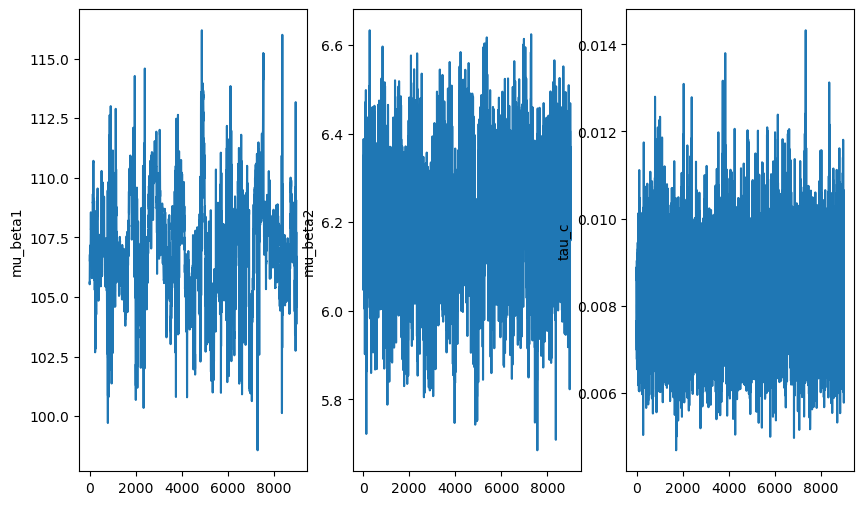

In [106]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
ylabs = ["mu_beta1", "mu_beta2", "tau_c"]
mu_beta = chain['mu_beta']
tau_c = chain['tau_c']
burnin = 1000
mu_beta1 = chain['mu_beta'][burnin:, 0]
mu_beta2 = chain['mu_beta'][burnin:, 1]
tau_c_burn = tau_c[burnin:]
ch = [mu_beta1, mu_beta2, tau_c_burn]
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(ch[i])
    plt.ylabel(ylabs[i])
plt.savefig("deuxieme.png")

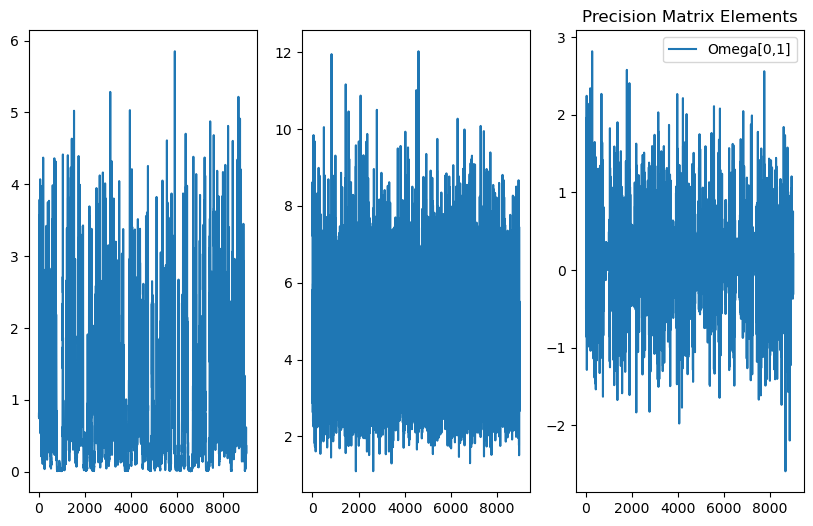

In [74]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.plot(chain['Omega'][burnin:, 0, 0], label='Omega[0,0]')
plt.subplot(1, 3, 2)
plt.plot(chain['Omega'][burnin:, 1, 1], label='Omega[1,1]')
plt.subplot(1, 3, 3)
plt.plot(chain['Omega'][burnin:, 0, 1], label='Omega[0,1]')
plt.title('Precision Matrix Elements')
plt.legend()

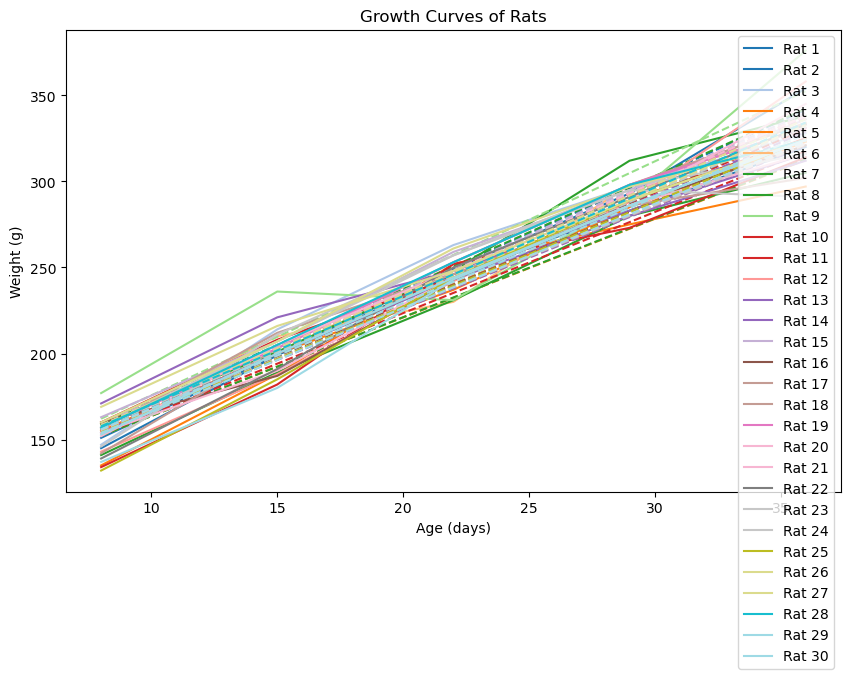

In [121]:
post_mean_latent_beta1 = np.mean(latent_beta[:, :, 0], axis=0)  
post_mean_latent_beta2 = np.mean(latent_beta[:, :, 1], axis=0) 

colors = plt.cm.tab20(np.linspace(0, 1, 30))
# Tracer les courbes de croissance
plt.figure(figsize=(10, 6))

for i in range(30):
    plt.plot(x, y[i], label=f'Rat {i+1}', color=colors[i])

    # Calculer l'intercept et la pente pour chaque rat
    intercept = post_mean_latent_beta1[i]
    slope = post_mean_latent_beta2[i]

    # Tracer la ligne de régression
    plt.plot(x, intercept + slope * x, linestyle='--', color=colors[i])

plt.xlabel('Age (days)')
plt.ylabel('Weight (g)')
plt.title('Growth Curves of Rats')
plt.legend()
plt.savefig("allrat2.png")
plt.show()


In [100]:
import numpy as np

mean_mubeta1 = np.mean(mu_beta1, axis=0)
variance_mubeta1 = np.var(mu_beta1, axis=0)
mean_mubeta2 = np.mean(mu_beta2, axis=0)
variance_mubeta2 = np.var(mu_beta2, axis=0)
mean_tauc = np.mean(1/np.sqrt(tau_c_burn), axis=0)
variance_tauc = np.var(1/np.sqrt(tau_c_burn), axis=0)

print(mean_mubeta1)
print(np.sqrt(variance_mubeta1))
print(mean_mubeta2)
print(np.sqrt(variance_mubeta2))
print(mean_tauc)
print(np.sqrt(variance_tauc))


106.92279074612966
2.152758325563363
6.198484566885869
0.12824304194488825
11.116888725031037
0.7547466258801061


In [104]:
print(np.quantile(mu_beta1, [0.025, 0.975]))
print(np.quantile(mu_beta2, [0.025, 0.975]))
print(np.quantile(1/np.sqrt(tau_c_burn), [0.025, 0.975]))

[102.31660114 111.02047628]
[5.94568048 6.44858367]
[ 9.71598805 12.68129796]
